<img style="float: left; margin: 30px 15px 15px 15px;" src="https://oci02.img.iteso.mx/Identidades-De-Instancia/ITESO/Logos%20ITESO/Logo-ITESO-Principal.jpg" width="500" height="250" /> 
    
    
#### <font color='navy'> Proyecto. Simulación de Procesos Financieros.

Profesor: Alan Omar Topete Salazar.

- Ivanna Herrera Ibarra
- Arantza Gomez Haro Gamboa
- Javier Alejandro Fajardo López
- Luis Fernando Márquez Bañuelos

## <font color='navy'> Librerías

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)

## <font color='navy'> Stocks S&P 500

In [2]:
df = pd.read_csv('sp_500.csv')
tickers = df['Symbol'].tolist()
tickers = [ticker for ticker in tickers if ticker not in ['FRC', 'FISV', 'ATVI', 'DISH', 'ABC', 'PKI', 'FLT', 'WRK', 'CDAY', 'PEAK', 'CTLT', 'PXD', 'MRO', 'RE', 'BRK.B', 'BF.B']]

start_date = '2024-01-01'
end_date = '2025-04-24'

data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close'][tickers]
rt = data.pct_change().dropna()

mu = rt.mean() * 252
sigma = rt.std() * np.sqrt(252)

metricas = pd.DataFrame({
    'Rendimiento': mu,
    'Volatilidad': sigma,
})

YF.download() has changed argument auto_adjust default to True


## <font color='navy'> Filtrado de Empresas

In [3]:
df_filtered = metricas[(metricas['Volatilidad'] > 0.3) & (metricas['Rendimiento'] > 0.20)]
df_filtered = df_filtered.copy()
df_filtered['Sharpe'] = (df_filtered['Rendimiento'] - 0.04) / df_filtered['Volatilidad']
df_filtered = df_filtered.sort_values(by='Sharpe', ascending=False).head(5)
df_filtered

,Rendimiento,Volatilidad,Sharpe
Ticker,,,
NFLX,0.676879,0.332201,1.917147
HWM,0.752072,0.376510,1.891245
TRGP,0.603586,0.316823,1.778867
GE,0.569036,0.336487,1.572232
NRG,0.653072,0.448966,1.365520


## <font color='navy'> Métricas de Acciones Seleccionadas

In [4]:
pd.set_option('display.float_format', '{:.2%}'.format)
tickers = df_filtered.index.to_list()
start_date = '2024-01-01'
end_date = '2025-04-24'

data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close'][tickers]
rt = data.pct_change().dropna()

mu = rt.mean() * 252
sigma = rt.std() * np.sqrt(252)

metricas = pd.DataFrame({
    'Rendimiento': mu,
    'Volatilidad': sigma
})
metricas.T

Ticker,NFLX,HWM,TRGP,GE,NRG
Rendimiento,67.69%,75.21%,60.36%,56.90%,65.31%
Volatilidad,33.22%,37.65%,31.68%,33.65%,44.90%


In [5]:
pd.reset_option('display.float_format')
prices_df = pd.DataFrame({
    'Precio Final': data.iloc[-1],
})
prices_df.T

Ticker,NFLX,HWM,TRGP,GE,NRG
Precio Final,1049.589966,129.699997,171.382339,193.679993,101.63028


## <font color='navy'> Ejecución de Estrategia

In [6]:
strikes = [900, 150, 200, 150, 130]

In [7]:
class OptionPayoff:
    def __init__(self) -> None:
        pass

    @staticmethod
    def long_call_payoff(st, k, premium):
        return np.maximum(st - k, 0) - premium
    
    @staticmethod
    def short_call_payoff(st, k, premium):
        return premium - np.maximum(st - k, 0)
    
    @staticmethod
    def long_put_payoff(st, k, premium):
        return np.maximum(k - st, 0) - premium
    
    @staticmethod
    def short_put_payoff(st, k, premium):
        return premium - np.maximum(k - st, 0)

In [8]:
class MultiStraddle:
    def __init__(self, tickers, start_date, end_date, strikes, n_sims=100_000):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.strikes = strikes
        self.n_sims = n_sims
        self.option = OptionPayoff()

        self.data = yf.download(self.tickers, self.start_date, self.end_date, progress=False)['Close'][self.tickers]
        self.rt = self.data.pct_change().dropna()
        self.mu = self.rt.mean().values
        self.sigma = self.rt.std().values
        self.anual_sigma = self.sigma * np.sqrt(252)
        self.last_price = self.data.iloc[-1].values

    def simulate_price_normal(self, mu, sigma, last_price):
        Z = np.random.normal(size=(self.n_sims, 252))
        returns = mu + sigma * Z
        cumulative_returns = (returns + 1).cumprod(axis=1)
        return last_price * cumulative_returns
    
    def simulate_price(self, mu, sigma, last_price):
        Z = np.random.normal(size=(self.n_sims // 2, 252))
        Z_antithetic = -Z
        Z_full = np.vstack((Z, Z_antithetic))
        returns = mu + sigma * Z_full
        cumulative_returns = (returns + 1).cumprod(axis=1)
        return last_price * cumulative_returns

    def black_scholes_price(self, So, K, T, rf, sigma, option_type='call'):
        d1 = (np.log(So / K) + (rf + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == 'call':
            price = (So * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-rf * T) * norm.cdf(d2, 0.0, 1.0))
        else:
            price = (K * np.exp(-rf * T) * norm.cdf(-d2, 0.0, 1.0) - So * norm.cdf(-d1, 0.0, 1.0))
        return price

    def american_option_price(self, So, K, T, rf, sigma, n, option_type='call'):
        dt = T / n
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        disc = np.exp(-rf * dt)
        p = (np.exp(rf * dt) - d) / (u - d)
        j = np.arange(n + 1)
        ST = So * (u ** (n - j)) * (d ** j)

        option_values = np.maximum(K - ST, 0.0) if option_type == 'put' else np.maximum(ST - K, 0.0)

        for i in range(n - 1, -1, -1):
            ST = ST[:-1] / u
            option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])
            exercise = np.maximum(K - ST, 0.0) if option_type == 'put' else np.maximum(ST - K, 0.0)
            option_values = np.maximum(option_values, exercise)

        return option_values[0]

    def straddle_payoff(self, st, k, premium_call, premium_put):
        return np.maximum(st - k, 0) - premium_call + np.maximum(k - st, 0) - premium_put

    def plot_simulations(self, prices, ticker):
        plt.figure(figsize=(8, 4))
        plt.plot(prices[:5000, :].T)
        plt.title(f'Simulated Price Paths for {ticker}')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.show()

    def plot_payoffs(self, st, long_calls, long_puts, strat_payoff, ticker):
        plt.figure(figsize=(10, 6))
        plt.plot(st, long_calls, label='Long Call Payoff', linestyle='--', color='indianred', alpha=0.5)
        plt.plot(st, long_puts, label='Long Put Payoff', linestyle='--', color='navy', alpha=0.5)
        plt.plot(st, strat_payoff, label='Strategy Payoff', color='black')
        plt.title(f'Payoff Diagrams {ticker}')
        plt.xlabel('Stock Price at Expiration')
        plt.ylabel('Payoff')
        plt.legend()
        plt.grid()
        plt.show()

    def execute(self, periods=[20, 62, 125, 251], times=[1/12, 1/4, 1/2, 1]):
        rows = 10_000
        st = np.linspace(0, 800, rows)

        for i in range(len(self.tickers)):
            ticker = self.tickers[i]
            prices = self.simulate_price(self.mu[i], self.sigma[i], self.last_price[i])
            display(HTML(f"<span style='font-size:20px'>{ticker}</span>"))
            self.plot_simulations(prices, ticker)

            for p, t in zip(periods, times):
                k = self.strikes[i]
                premium_call = self.black_scholes_price(self.last_price[i], k, t, 0.04, self.anual_sigma[i], 'call')
                premium_put = self.black_scholes_price(self.last_price[i], k, t, 0.04, self.anual_sigma[i], 'put')

                long_call = self.option.long_call_payoff(st[:, None], k, premium_call)
                long_put = self.option.long_put_payoff(st[:, None], k, premium_put)
                strat_payoff = self.straddle_payoff(st[:, None], k, premium_call, premium_put)

                self.plot_payoffs(st, long_call, long_put, strat_payoff, ticker)

                final_prices = prices[:, p]
                profits = self.straddle_payoff(final_prices, k, premium_call, premium_put)
                expected_profit = np.mean(profits)
                cost = premium_call + premium_put
                pct_profit = expected_profit / cost
                conf_interval = [np.percentile(profits, 2.5), np.percentile(profits, 97.5)]
                win_rate = np.mean(profits > 0)

                print(f'Las ganancias esperadas ejerciendo las opciones a los {p+1} días son:')
                print(f'El profit esperado es de ${expected_profit:.2f}')
                print(f'El rendimiento esperado de la estrategia es de {pct_profit:.2%}')
                print(f'La probabilidad de obtener rendimiento positivo es de {win_rate:.2%}')
                print(f'El intervalo de confianza del 95% para el profit es de {conf_interval}')
                print()

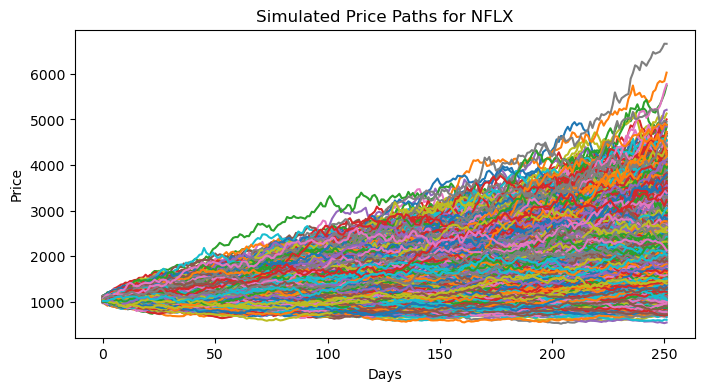

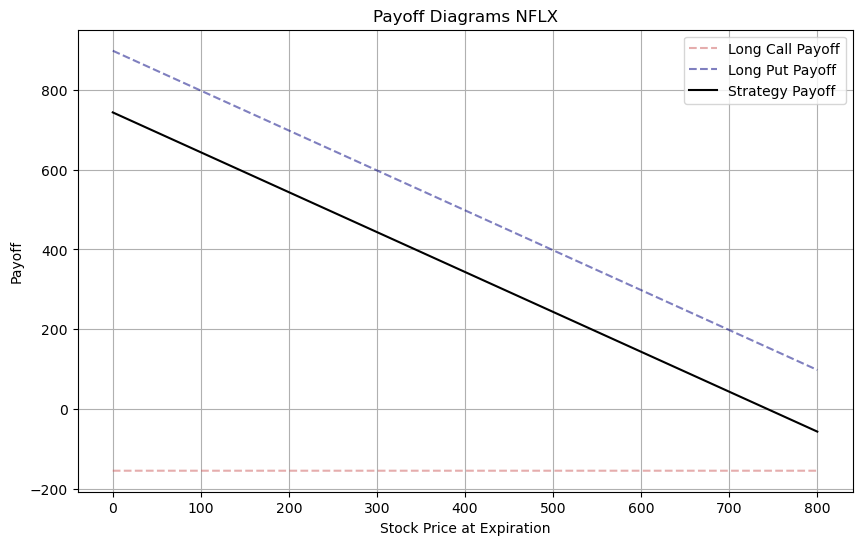

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $54.85
El rendimiento esperado de la estrategia es de 35.04%
La probabilidad de obtener rendimiento positivo es de 68.18%
El intervalo de confianza del 95% para el profit es de [-130.92717607363633, 275.2923456281273]



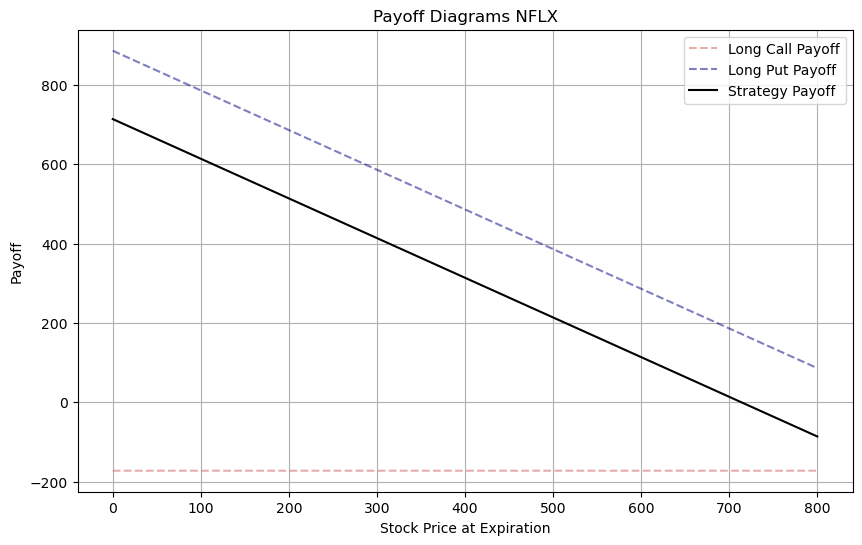

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $160.39
El rendimiento esperado de la estrategia es de 86.24%
La probabilidad de obtener rendimiento positivo es de 76.94%
El intervalo de confianza del 95% para el profit es de [-159.59308170279743, 611.0185548831874]



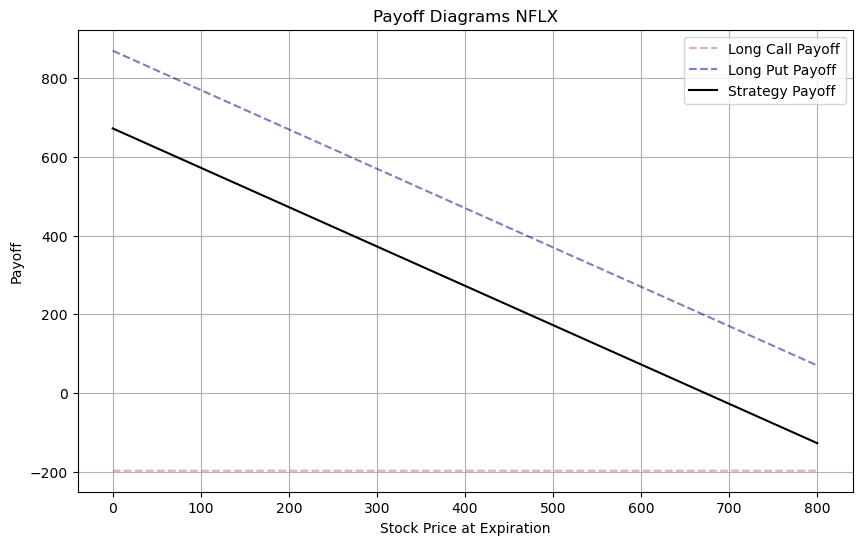

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $347.69
El rendimiento esperado de la estrategia es de 152.81%
La probabilidad de obtener rendimiento positivo es de 84.60%
El intervalo de confianza del 95% para el profit es de [-183.14818168116852, 1140.0582244946584]



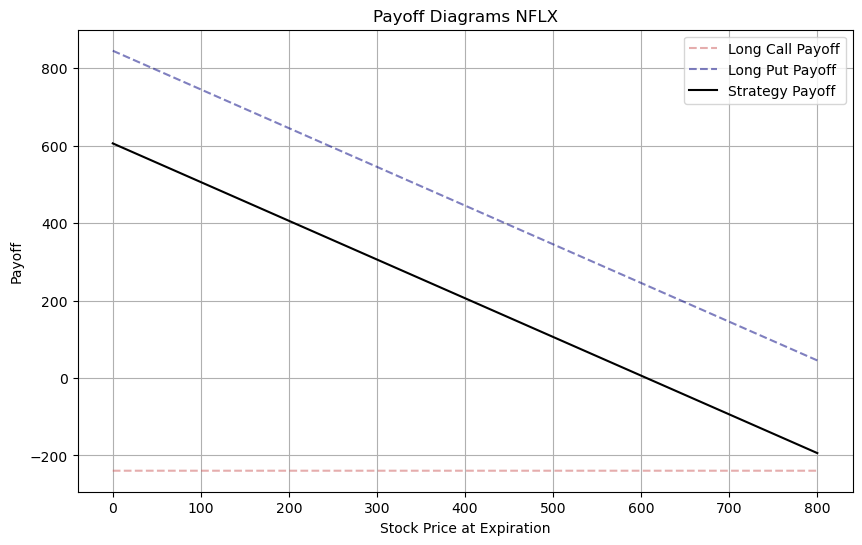

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $870.49
El rendimiento esperado de la estrategia es de 296.31%
La probabilidad de obtener rendimiento positivo es de 93.20%
El intervalo de confianza del 95% para el profit es de [-159.90833899713044, 2538.2801956744142]



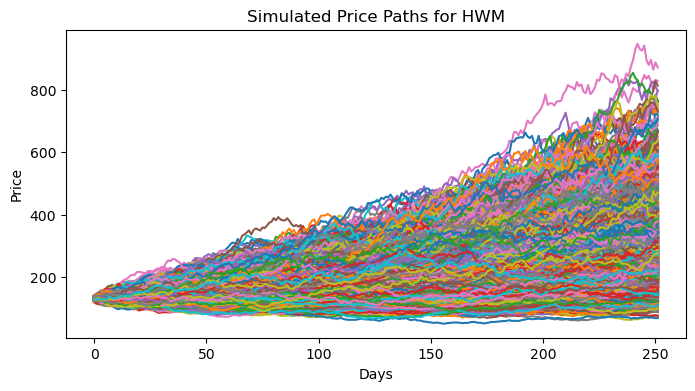

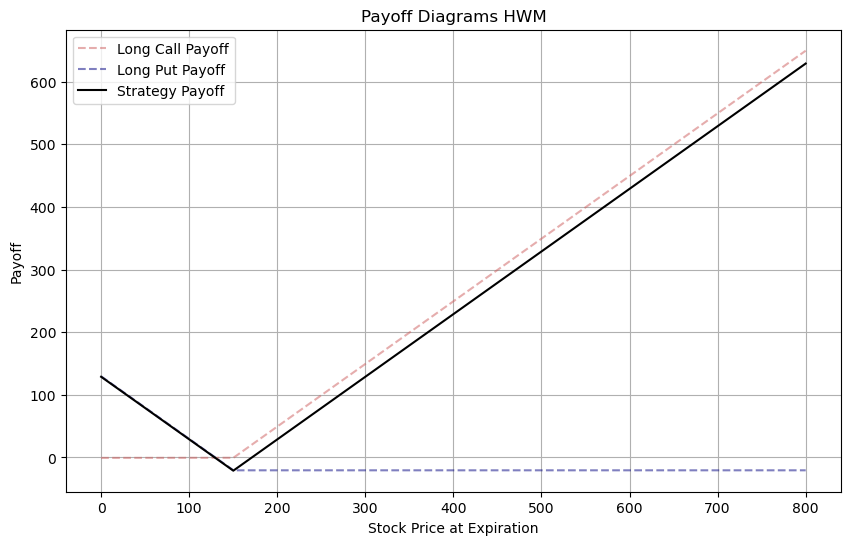

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-5.29
El rendimiento esperado de la estrategia es de -24.98%
La probabilidad de obtener rendimiento positivo es de 29.87%
El intervalo de confianza del 95% para el profit es de [-20.43949606652804, 18.157414474325094]



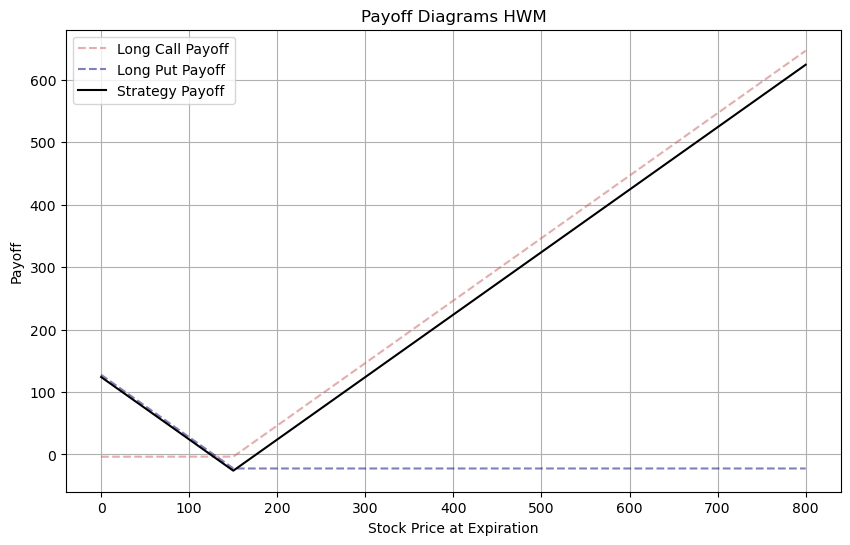

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $-2.45
El rendimiento esperado de la estrategia es de -9.43%
La probabilidad de obtener rendimiento positivo es de 36.34%
El intervalo de confianza del 95% para el profit es de [-25.122146493604806, 45.876250041693766]



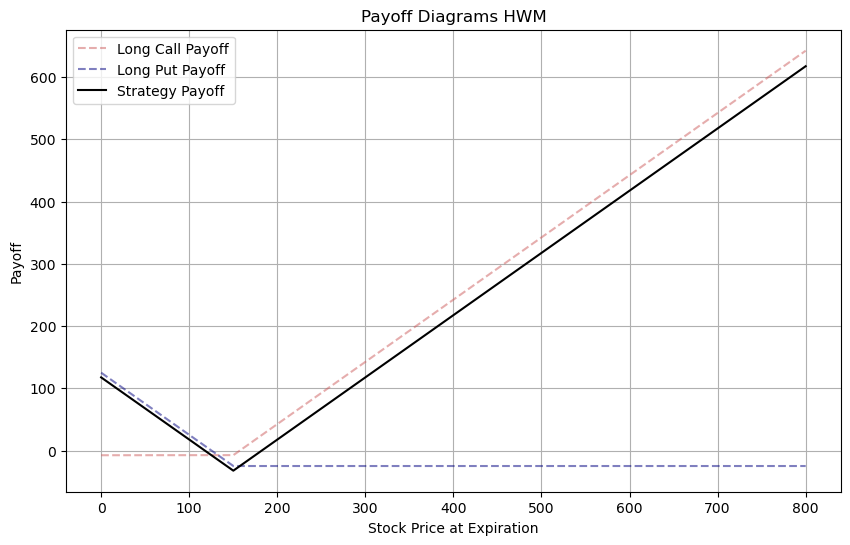

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $15.84
El rendimiento esperado de la estrategia es de 48.76%
La probabilidad de obtener rendimiento positivo es de 54.80%
El intervalo de confianza del 95% para el profit es de [-30.847943257021008, 124.03567683202583]



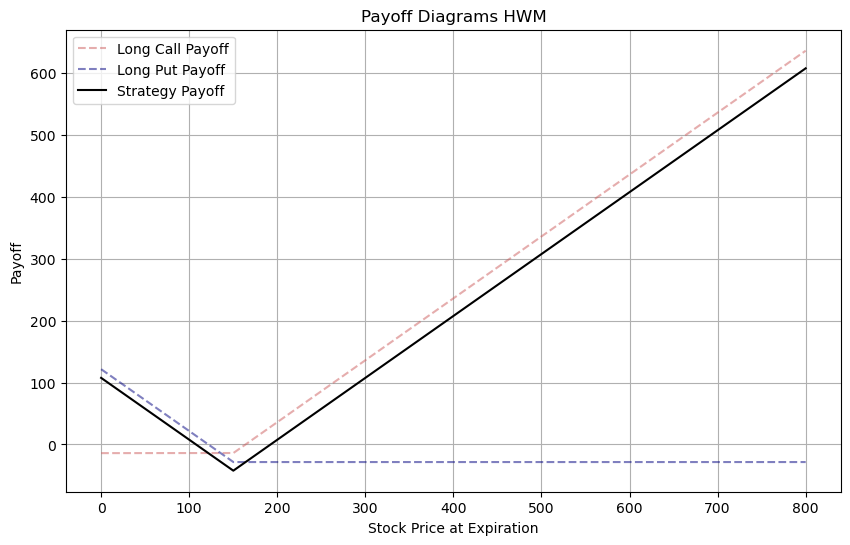

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $85.73
El rendimiento esperado de la estrategia es de 201.91%
La probabilidad de obtener rendimiento positivo es de 78.84%
El intervalo de confianza del 95% para el profit es de [-37.61431275367794, 340.41511078034216]



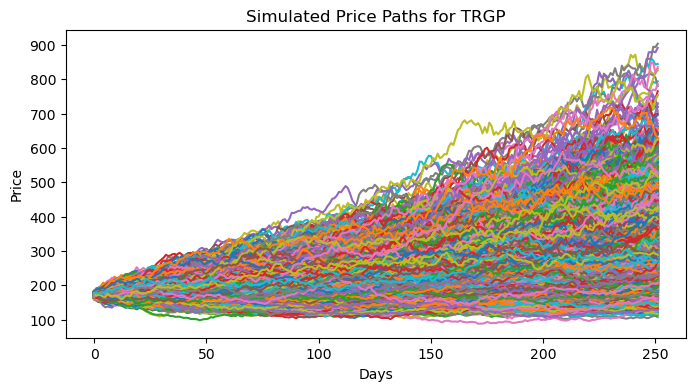

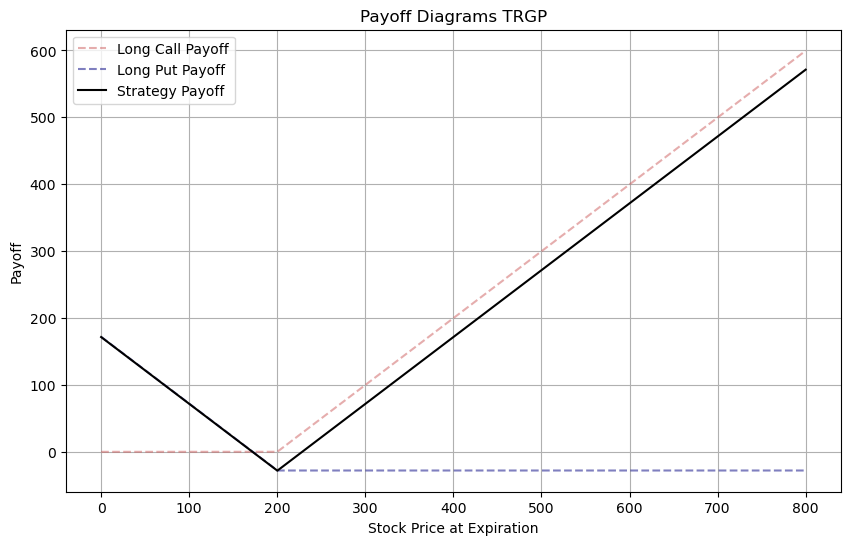

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-6.64
El rendimiento esperado de la estrategia es de -23.18%
La probabilidad de obtener rendimiento positivo es de 31.03%
El intervalo de confianza del 95% para el profit es de [-27.489486910577746, 21.74484916595814]



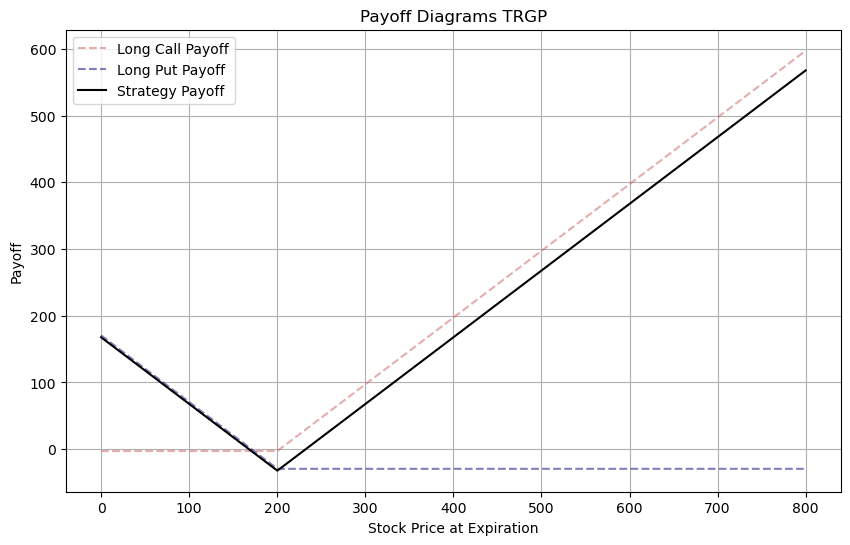

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $-7.22
El rendimiento esperado de la estrategia es de -22.31%
La probabilidad de obtener rendimiento positivo es de 30.13%
El intervalo de confianza del 95% para el profit es de [-31.354356191028646, 39.05665899902824]



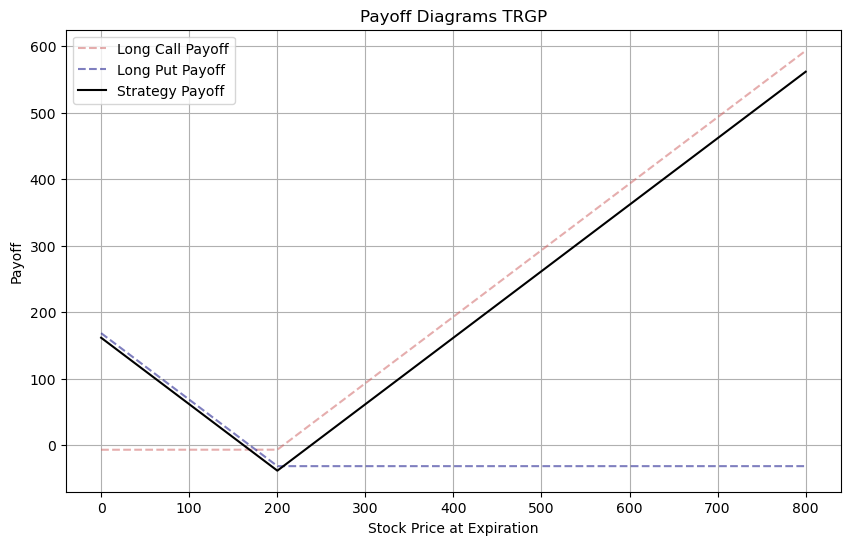

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $7.99
El rendimiento esperado de la estrategia es de 20.76%
La probabilidad de obtener rendimiento positivo es de 47.36%
El intervalo de confianza del 95% para el profit es de [-36.83112312877895, 111.70088071791834]



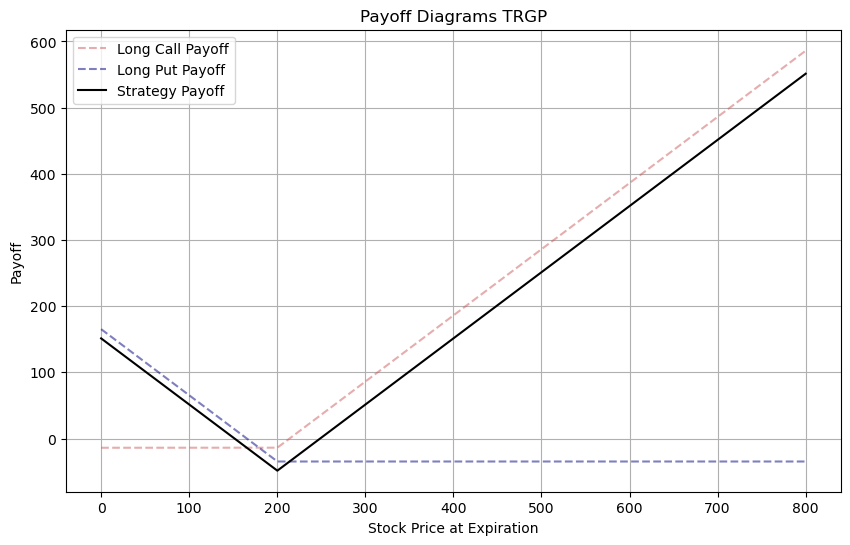

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $69.92
El rendimiento esperado de la estrategia es de 143.62%
La probabilidad de obtener rendimiento positivo es de 73.21%
El intervalo de confianza del 95% para el profit es de [-44.10911498724365, 303.29901031926806]



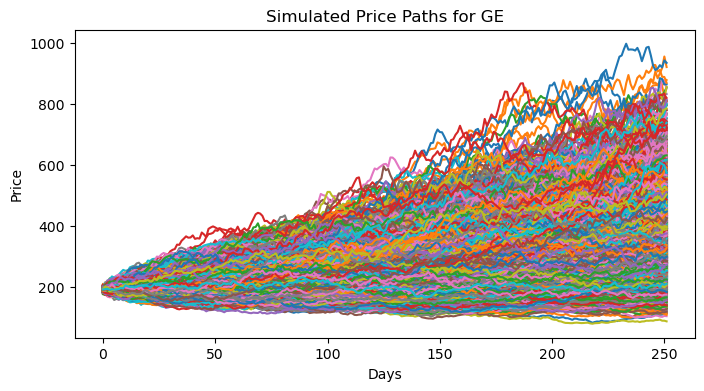

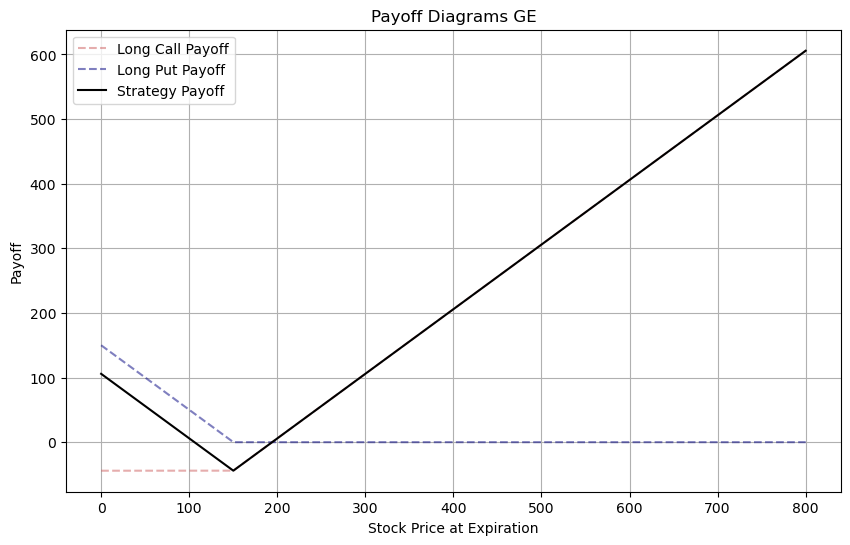

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $8.87
El rendimiento esperado de la estrategia es de 20.06%
La probabilidad de obtener rendimiento positivo es de 66.18%
El intervalo de confianza del 95% para el profit es de [-27.42853660245742, 50.42735604933784]



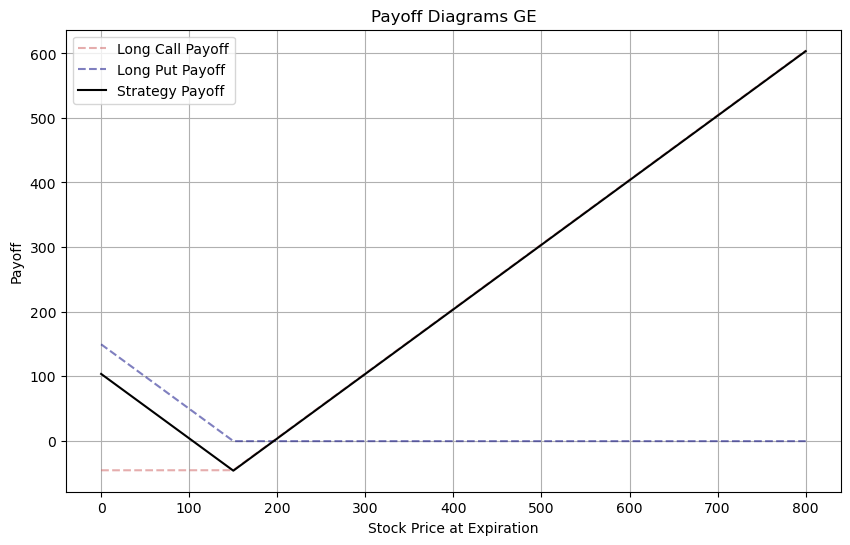

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $26.92
El rendimiento esperado de la estrategia es de 57.81%
La probabilidad de obtener rendimiento positivo es de 74.98%
El intervalo de confianza del 95% para el profit es de [-36.79018638863352, 109.39311003584211]



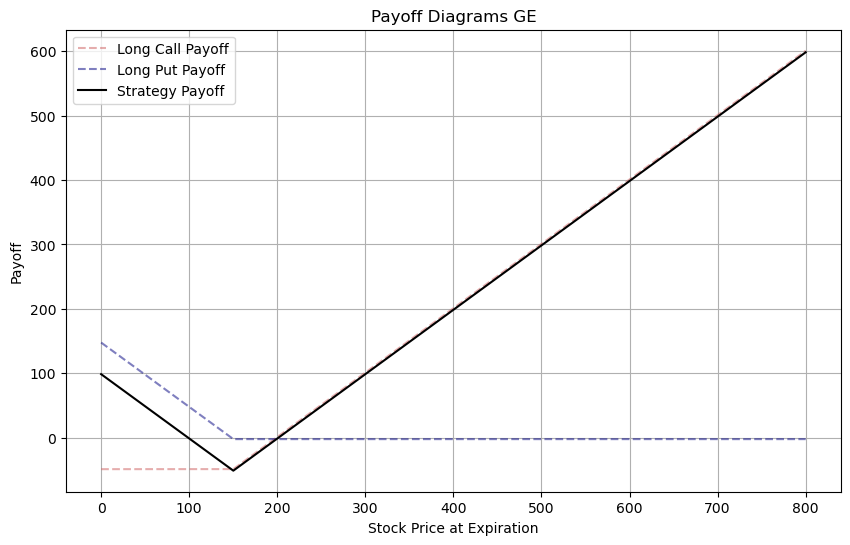

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $56.27
El rendimiento esperado de la estrategia es de 109.19%
La probabilidad de obtener rendimiento positivo es de 81.75%
El intervalo de confianza del 95% para el profit es de [-40.724617936111024, 197.2415465926758]



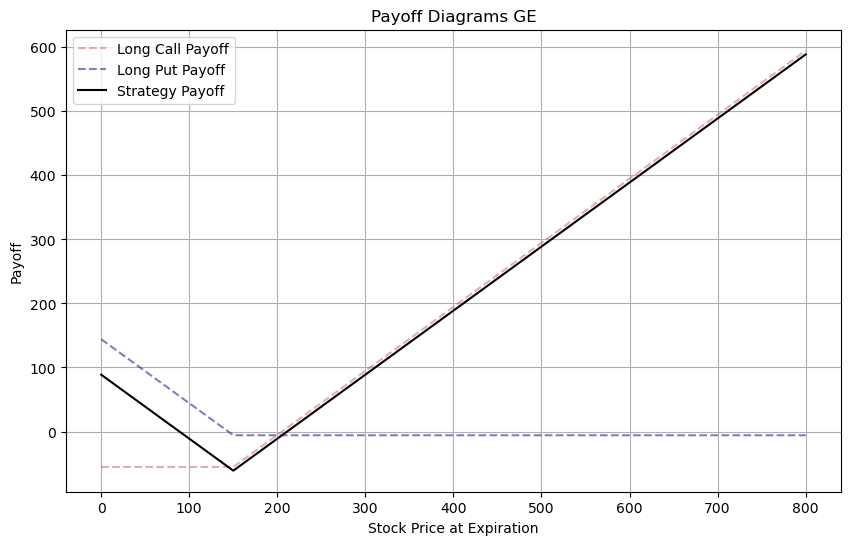

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $131.10
El rendimiento esperado de la estrategia es de 214.19%
La probabilidad de obtener rendimiento positivo es de 89.73%
El intervalo de confianza del 95% para el profit es de [-41.01177106326074, 413.79019114807915]



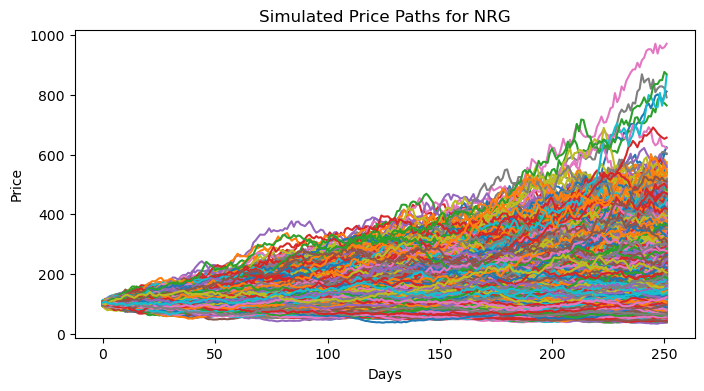

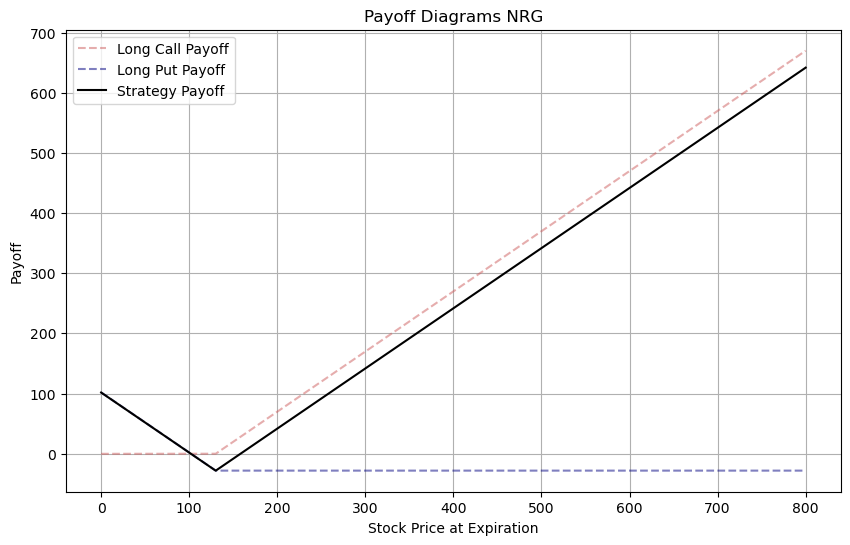

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-4.68
El rendimiento esperado de la estrategia es de -16.53%
La probabilidad de obtener rendimiento positivo es de 36.25%
El intervalo de confianza del 95% para el profit es de [-26.59921813668657, 19.316823752341957]



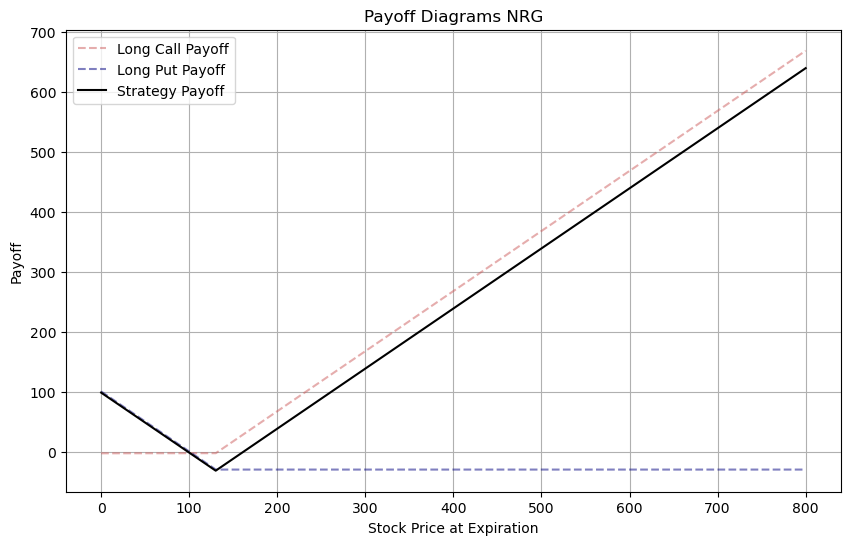

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $-7.05
El rendimiento esperado de la estrategia es de -22.80%
La probabilidad de obtener rendimiento positivo es de 31.16%
El intervalo de confianza del 95% para el profit es de [-29.86468369672578, 29.550572426400073]



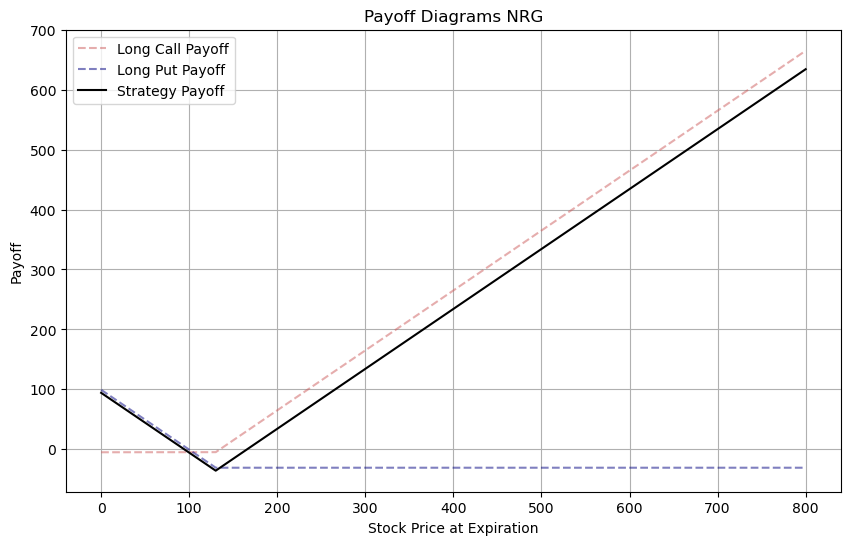

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $-0.69
El rendimiento esperado de la estrategia es de -1.92%
La probabilidad de obtener rendimiento positivo es de 38.31%
El intervalo de confianza del 95% para el profit es de [-34.53906288698154, 83.53066560405877]



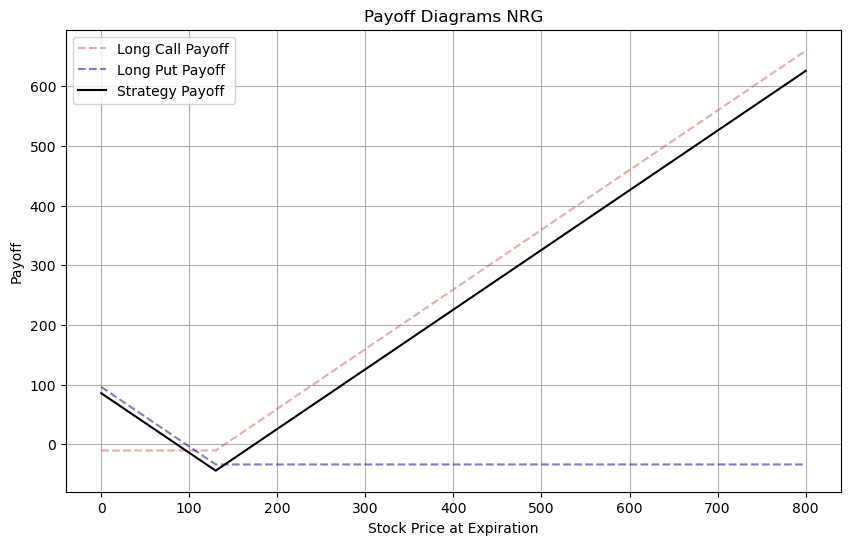

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $34.95
El rendimiento esperado de la estrategia es de 78.85%
La probabilidad de obtener rendimiento positivo es de 56.58%
El intervalo de confianza del 95% para el profit es de [-42.013308100539376, 251.81192163674342]



In [9]:
straddle = MultiStraddle(tickers, start_date, end_date, strikes)
straddle.execute()